In [1]:
import sys
print(sys.path)
import geopandas as gpd
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from datacube.utils import geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, map_shapefile
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.classification import HiddenPrints
from deafrica_tools.dask import create_local_dask_cluster
from odc.algo import geomedian_with_mads
from deafrica_tools.bandindices import calculate_indices
from PIL import Image

['/home/jovyan/cropmapping_open_datacube_dea/Vision model', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/jovyan/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/jovyan/.ipython']


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34013 Dashboard: /user/youssef.benallal@emines.um6p.ma/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [2]:
dc = datacube.Datacube(app='Analyse_multiple_polygons')

In [3]:
time_range = ('2019-02', '2019-04')

vector_file = '/home/jovyan/cropmapping_open_datacube_dea/Numeric data models/data/crop_vectors_v4.geojson'
attribute_col = 'id'

products = ['s2_l2a']
measurements = ['red', 'green', 'blue', 'nir']
resolution = (-10, 10)
output_crs = 'EPSG:6933'


query = {'time': time_range,
         'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         }

query

{'time': ('2019-02', '2019-04'),
 'measurements': ['red', 'green', 'blue', 'nir'],
 'resolution': (-10, 10),
 'output_crs': 'EPSG:6933'}

In [4]:
crop_vectors = gpd.read_file(vector_file)
gdf = crop_vectors[(~crop_vectors['culture'].isin(['blé tendre', 'blé dur', 'orge'])) & (crop_vectors['area']>8)].reset_index(drop=True)
gdf['id'] = gdf.index

In [5]:
# Dictionary to save results 
results = {}

# A progress indicator
i = 0

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    
    print(" Feature {:02}/{:02}\r".format(i + 1, len(gdf)),
                  end='')
    
    # Get the geometry
    geom = geometry.Geometry(row.geometry.__geo_interface__,
                             geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))
    
    # Update dc query with geometry      
    query.update({'geopolygon': geom}) 
    
    # Load landsat (hide print statements)
    with HiddenPrints():
        ds = load_ard(dc=dc, 
              products=products,
              min_gooddata=0.75,                  
              group_by='solar_day',
              dask_chunks={'x':50, 'y':50},
              **query)
        ds = calculate_indices(ds, index=['NDVI'], satellite_mission='s2')
        ds = geomedian_with_mads(ds, compute_mads=True, compute_count=False).compute()

    # Generate a polygon mask to keep only data within the polygon
    with HiddenPrints():
        mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({str(row[attribute_col]) : ds})
    
    # Update counter
    i += 1

/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


In [6]:
from typing import Tuple
from typing import Union
from typing import Optional
import odc.ui
from odc.ui import to_png_data
from odc.ui import mk_data_uri
from odc.ui import to_jpeg_data
from odc.algo import to_rgba, is_rgb
import xarray as xr

def xr_bounds(x, crs=None) -> Tuple[Tuple[float, float], Tuple[float, float]]:

    def get_range(a: np.ndarray) -> Tuple[float, float]:
        b = (a[1] - a[0]) * 0.5
        return a[0] - b, a[-1] + b

    if "latitude" in x.coords:
        r1, r2 = (get_range(a.values) for a in (x.latitude, x.longitude))
        p1, p2 = ((r1[i], r2[i]) for i in (0, 1))
        return p1, p2

    if crs is None:
        geobox = getattr(x, "geobox", None)
        if geobox:
            crs = geobox.crs

    if crs is None:
        raise ValueError("Need to supply CRS or use latitude/longitude coords")

    if not all(d in x.coords for d in crs.dimensions):
        raise ValueError("Incompatible CRS supplied")

    (t, b), (l, r) = (get_range(x.coords[dim].values) for dim in crs.dimensions)

    l, b, r, t = box(l, b, r, t, crs).to_crs(epsg4326).boundingbox
    return ((t, r), (b, l))



def mk_image_overlay(
    xx: Union[xr.Dataset, xr.DataArray],
    clamp: Optional[float] = None,
    bands: Optional[Tuple[str, str, str]] = None,
    layer_name="Image",
    fmt="png",
    **opts
):
    """Create ipyleaflet.ImageLayer from raster data.
    xx - xarray.Dataset that will be converted to RGBA or
         xarray.DataArray that is already in RGB(A) format
    clamp, bands -- passed on to to_rgba(..), only used when xx is xarray.Dataset
    Returns
    =======
    ipyleaflet.ImageOverlay or a list of them one per time slice
    """

    comp, mime = dict(
        png=(to_png_data, "image/png"),
        jpg=(to_jpeg_data, "image/jpeg"),
        jpeg=(to_jpeg_data, "image/jpeg"),
    ).get(fmt.lower(), (None, None))

    if comp is None or mime is None:
        raise ValueError("Only support png an jpeg formats")

    if "time" in xx.dims:
        nt = xx.time.shape[0]
        if nt == 1:
            xx = xx.isel(time=0)
        else:
            return [
                mk_image_overlay(
                    xx.isel(time=t),
                    clamp=clamp,
                    bands=bands,
                    layer_name="{}-{}".format(layer_name, t),
                    fmt=fmt,
                    **opts
                )
                for t in range(nt)
            ]

    if isinstance(xx, xr.Dataset):
        rgba = to_rgba(xx, clamp=clamp, bands=bands)
    else:
        if not is_rgb(xx):
            raise ValueError("Expect RGB xr.DataArray")
        rgba = xx

    im_url = mk_data_uri(comp(rgba.values, **opts), mime)
    return im_url, rgba

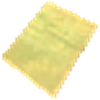

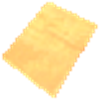

In [124]:
im_layer = mk_image_overlay(results['9'], clamp=900, bands=['red', 'green', 'blue'] , fmt='png')
im_layer_ = mk_image_overlay(results['9'], clamp=900, bands=['nir', 'green', 'blue'] , fmt='png')
im_rgb  = Image.fromarray(im_layer[1].values)
im_nir  = Image.fromarray(im_layer_[1].values)
display(im_rgb.resize((100, 100)), im_nir.resize((100, 100)))

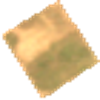

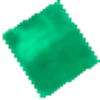

In [139]:
im_layer = mk_image_overlay(results['81'], clamp=900, bands=['red', 'green', 'blue'] , fmt='png')
im_layer_ = mk_image_overlay(results['81'], clamp=900, bands=['NDVI', 'green', 'blue'] , fmt='png')
im_rgb  = Image.fromarray(im_layer[1].values)
im_nir  = Image.fromarray(im_layer_[1].values)
display(im_rgb.resize((100, 100)), im_nir.resize((100, 100)))

In [ ]:
base_folder = '/home/jovyan/cropmapping_open_datacube_dea/Vision model/CROPSMAR_19/Wheat/'
for i in results.keys():
    Image.fromarray(mk_image_overlay(results['{}'.format(i)], clamp=900, bands=['red', 'green', 'blue'] , fmt='png')[1].values).resize((80, 80)).save(base_folder + "wheat_{}.png".format(i))

In [8]:
base_folder = '/home/jovyan/cropmapping_open_datacube_dea/Vision model/CROPSMAR_19/Non_wheat/'
for i in results.keys():
    Image.fromarray(mk_image_overlay(results['{}'.format(i)], clamp=900, bands=['red', 'green', 'blue'] , fmt='png')[1].values).resize((80, 80)).save(base_folder + "non_wheat_{}.png".format(i))